# Bachelor Notebook

## Import Statements

contains the import statements for all necessary packages

In [1]:
from os import listdir
from os.path import isfile, join
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from fastai.data.all import *
from fastai.vision.all import *
#from fastai.vision.image import *
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
import shutil
from PIL import Image
from matplotlib.pyplot import imshow
#from IPython.core.debugg

## Define paths
define the paths to the relevant data

In [2]:
data_path=r"D:\Bachelor\data"
image_path=data_path+r"\ImageFiles"
ship_image_path=image_path+r"\ships"
ship_csv_path=data_path+r"shipsAIS_2017_Zone17.csv"
nonship_image_path=image_path+r"\non_ships"
nonship_csv_path=data_path+r"\nonshipsAIS_2017_Zone17.csv"

## Search for misplaced directories
Some image directories are misplaced, instead of being located in ships or nonships, certain subdirectories are located in other subdirectories. The following method finds the affected subdirectories and prints them.

In [ ]:
def get_misplaced_directories(path):
    misplaced_directories=[]
    for d in listdir(path):
        if os.path.isdir(join(path,d)):
            for f in listdir(join(path,d)):
                if os.path.isdir(join(join(path,d),f)):
                    misplaced_directories.append(join(path,d))
    return misplaced_directories

In [ ]:
get_misplaced_directories(ship_image_path)

In [ ]:
get_misplaced_directories(nonship_image_path)

## Correct misplaced directories
The following two methods correct the location of the aforementioned misplaced subdirectories.

In [ ]:
def correct_misplaced_directories(path):
    misplaced_directories=[]
    main_dir=listdir(path)
    for d in main_dir:
        sub_dir=join(path,d)
        if os.path.isdir(sub_dir):
            for f in listdir(sub_dir):
                current_path=join(sub_dir,f)
                if os.path.isdir(current_path):
                    #misplaced_directories.append(current_directory)
                    correct_misplaced_directories_r(path,current_path)
                    #correct dir
                    if f in main_dir:
                        shutil.rmtree(current_path)
                    else:
                        shutil.move(current_path,path)

def correct_misplaced_directories_r(main_path,path):
    main_dir=listdir(main_path)
    for d in listdir(path):
        current_path=join(path,d)
        if os.path.isdir(current_path):
            correct_misplaced_directories_r(main_path,current_path)
            #correct dir
            if d in main_dir:
                shutil.rmtree(current_path)
            else:
                shutil.move(current_path,main_path)
        

In [ ]:
correct_misplaced_directories(ship_image_path)
correct_misplaced_directories(nonship_image_path)

## Test

In [4]:
nonship_image_files = []# [f for f in dir1 for dir1 in listdir(nonship_image_path) if isfile(join(nonship_image_path,join(dir, f))) and ".tif" in f]
for directory in listdir(nonship_image_path):
    nonship_image_files+=[join(join(nonship_image_path,directory),f) for f in os.listdir(join(nonship_image_path,directory)) if ".tif" in f and "udm" not in f]
#ship_image_files = [f for f in listdir(ship_image_path) if isfile(join(ship_image_path, f))]
#ship_image_files = []# [f for f in dir1 for dir1 in listdir(nonship_image_path) if isfile(join(nonship_image_path,join(dir, f))) and ".tif" in f]
ship_image_files=[]
for directory in listdir(ship_image_path):
    ship_image_files+=[join(join(ship_image_path,directory),f) for f in os.listdir(join(ship_image_path,directory)) if ".tif" in f and "udm" not in f]
nonship_images=[rasterio.open(f) for f in nonship_image_files]
ship_images=[rasterio.open(f) for f in ship_image_files] 

<IPython.core.display.Javascript object>


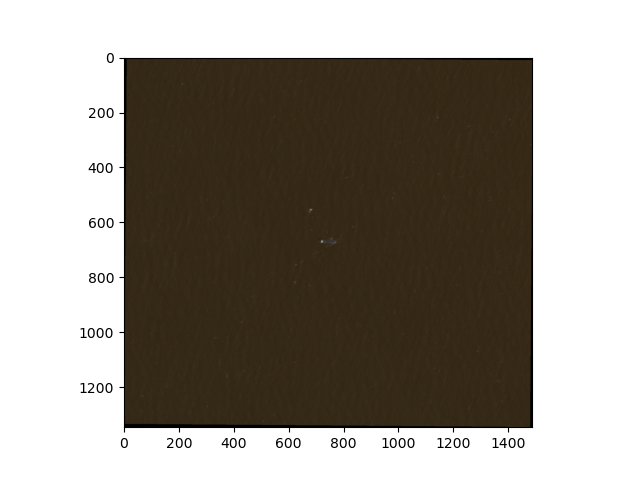

In [20]:
%matplotlib notebook
sim=ship_images[0]
arr=sim.read()
arr=np.swapaxes(arr,0,2)
#print(arr.shape)
arr=arr[:,:,:3]
m=arr.max()
#print(arr.min())
arr=arr/(m+1)*255
imshow(arr.astype(np.uint8))#,norm=matplotlib.colors.Normalize(0,32000))
#print(arr.astype(np.uint8).max())
#print(arr.astype(np.uint8).min())

## Test ImageReading

In [36]:
sim=ship_images[0]
arr=sim.read()
arr=np.swapaxes(arr,0,2)
#print(arr.shape)
arr=arr[:,:,:3]
m=arr.max()
#print(arr.min())
arr=arr/(m+1)*255
img=Image.fromarray(arr.astype(np.uint8),"RGB")
img.show()

## Getter functions
definition of get_items and get_y for DataBlocks

In [3]:
def get_4ch_tif_files(path):
    file_paths=[]
    for root,directories,files in os.walk(path):
        #print(root)
        file_paths+=[Path(join(root,f)) for f in files if ".tif" in f and "udm" not in f]
    return L(file_paths)

def get_data_y(item):
    return Path(item).parent.parent.name

In [ ]:
get_image_files??

In [ ]:
get_files??

In [ ]:
L??

In [ ]:
type(get_image_files(ship_image_path))
#type(get_image_files(ship_image_path)[0])

In [ ]:
type(get_4ch_tif_files(ship_image_path))

## Modified TensorImage

In [4]:
class TensorImage4Ch(TensorImage):
    def show(self, ctx=None, **kwargs):
        rgbTensor=self[:3,:,:]
        return show_image(rgbTensor, ctx=ctx, **{**self._show_args, **kwargs})
        

## Transform functions
transformation functions for the independent variable

In [5]:
width=-1
height=-1


def get_image(item):
    img=rasterio.open(item)
    b,g,r,n=img.read()
    channels=tuple([r,g,b,n])
    arr=np.dstack(channels)
    arr=(arr/32000)
    arr=(arr).astype(np.float32)
    t=TensorImage4Ch(image2tensor(torch.Tensor(arr)))
    t=t.type(torch.float32)
    #print(t.shape)
    return t#[:3,:,:]

class crop_middle(Transform):
    def __init__(self, size=400, randomnes=25):
        self.size = size
        self.randomnes = randomnes
    def encodes(self, x:TensorImage):
        data=x
        rows = data.shape[1]
        cols = data.shape[2]
        mid_row = int(rows/2)
        mid_col = int(cols/2)
        start_row = mid_row - int(self.size/2)
        start_col = mid_col - int(self.size/2)
        col_dist, row_dist = np.random.randint(low=-self.randomnes, high=self.randomnes, size=2)
        start_row += row_dist
        start_col += col_dist
        data = data[:,start_row : start_row+self.size, start_col: start_col+self.size]
        return data

## One Hot Encoded Category

In [6]:
#copied from https://github.com/fastai/fastai/blob/f633356359a29f8d869ce36659f7aa25660e946a/fastai/data/transforms.py#L230
class Categorize_OneHot(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, sort=True, add_na=False):
        if vocab is not None: vocab = CategoryMap(vocab, sort=sort, add_na=add_na)
        store_attr()

    def setups(self, dsets):
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o):
        try:
            #change to one-hot-encoding
            
            length=len(self.vocab.o2i)
            y_vec=torch.zeros(length)
            y_vec[self.vocab.o2i[o]]=1
            return TensorCategory(y_vec.type(torch.LongTensor))#TensorCategory(self.vocab.o2i[o])
        except KeyError as e:
            raise KeyError(f"Label '{o}' was not included in the training dataset") from e
    #change
    def decodes(self, o): 
        index=torch.argmax(o)
        return Category(self.vocab[index])

## Load Data
definition of the DataBlock

In [ ]:
Resize??

In [7]:
images=DataBlock(
    blocks=(TransformBlock([get_image]),TransformBlock(type_tfms=Categorize_OneHot(vocab=None, sort=True, add_na=False))),
    get_items=get_4ch_tif_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=get_data_y,
    item_tfms=crop_middle(size=300),
    batch_tfms=aug_transforms())

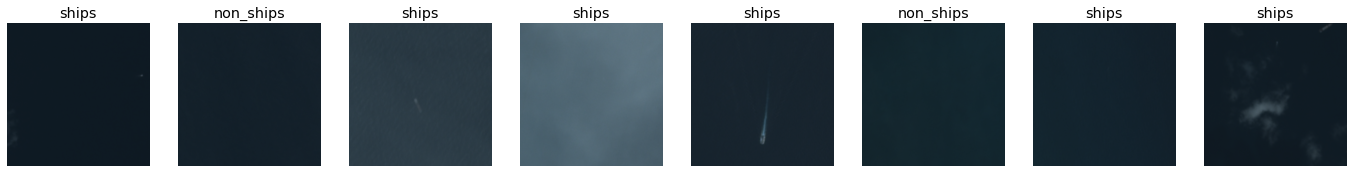

In [8]:
dls=images.dataloaders(image_path,num_workers=0)
dls.valid.show_batch(max_n=8, nrows=1)


In [8]:
dls.valid

In [12]:
x,y=first(dls.valid)

In [28]:
x.shape

(64, 4, 400, 400)

In [12]:
y.shape

NameError: name 'y' is not defined

## further tests

In [ ]:
nonship_images[5].shape


In [ ]:
show(ship_images[8].read(4))
np.max(ship_images[8].count)

In [ ]:
ship_images[7]

## Training

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

## Test

In [37]:
ts=aug_transforms()

In [10]:
from fastai.vision.models import *

In [12]:
resnet34??

## Network Test

In [ ]:
class Test_Net(nn.Module):
    def __init__(self):
        super.__init__(self)
    def forward(self,x):
        pass

In [14]:
first_test=nn.Sequential(nn.Conv2d(4,10,kernel_size=3,padding=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                         nn.Conv2d(10,8,kernel_size=3,padding=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                         nn.Conv2d(8,4,kernel_size=3,padding=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                         Flatten(),
                         nn.Linear(5476,100),nn.ReLU(),
                         nn.Linear(100,2),nn.Softmax(dim=1))

In [13]:
x=to_cpu(x)
first_test(x).shape

(64, 5476)

In [15]:
learn = Learner(dls, first_test, loss_func=F.cross_entropy, metrics=accuracy)

In [16]:
learn.fit_one_cycle(2, 0.01)

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss_forward

In [11]:
learn.summary()

TypeError: 'NoneType' object cannot be interpreted as an integer